Copyright Preferred Computational Chemistry, Inc. as contributors to Matlantis contrib project

In [ ]:
!pip install pandas matplotlib scipy ase

# # 初回使用時のみ、ライブラリのインストールをお願いします。

In [1]:
import pathlib
EXAMPLE_DIR = pathlib.Path("__file__").resolve().parent
INPUT_DIR = EXAMPLE_DIR / "input"
OUTPUT_DIR = EXAMPLE_DIR / "output"

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import glob, os

import ase
from ase.visualize import view
from ase.io import read, write
from ase.io import Trajectory

# ひとつひとつの温度で解析

In [3]:
trj = read(OUTPUT_DIR / "traj_and_log/MD_0423.traj", index="::10")
view(trj, viewer = "ngl")

In [4]:
Li_index = [i for i, x in enumerate(trj[0].get_chemical_symbols()) if x == 'Li']
print(len(Li_index))

80


In [5]:
positions_x = []
positions_y = []
positions_z = []

for i in range(len(trj)):
               positions_x.append(trj[i].get_positions()[Li_index,0])
               positions_y.append(trj[i].get_positions()[Li_index,1])
               positions_z.append(trj[i].get_positions()[Li_index,2])

In [6]:
# x,y,z軸ごとにmsd取得
msd_x = np.mean((positions_x-positions_x[0])**2, axis = 1)
msd_y = np.mean((positions_y-positions_y[0])**2, axis = 1)
msd_z = np.mean((positions_z-positions_z[0])**2, axis = 1)

In [7]:
# msd

msd = []
for i in range(len(trj)):
    msd0 = np.mean(np.sum((trj[i].get_positions()[Li_index]-trj[0].get_positions()[Li_index])**2, axis=1))
    msd.append(msd0)

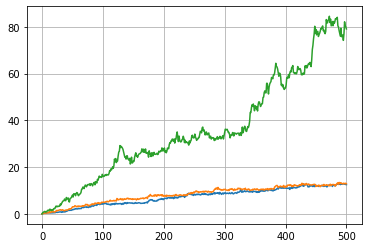

In [8]:
plt.plot(range(len(msd_x)), msd_x)
plt.plot(range(len(msd_y)), msd_y)
plt.plot(range(len(msd_z)), msd_z)
plt.grid(True)
#plt.xlim(0,100)
#plt.ylim(0,10)

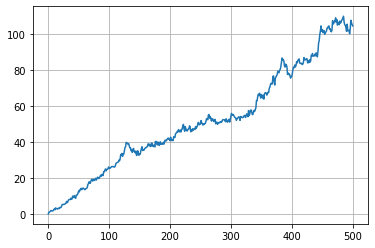

In [9]:
plt.plot(range(len(msd)), msd)
plt.grid(True)
#plt.xlim(0,100)
#plt.ylim(0,10)

In [10]:
slope, intercept, r_value, _, _ = stats.linregress(range(len(msd)), msd)
print(slope, intercept, r_value)
print (slope, "A^2/psec")

0.1993629565747036 1.8653720262908564 0.9821670051806577
0.1993629565747036 A^2/psec


In [11]:
np.log10(slope*1e-16*1e12/6)

-5.478506784721593

# まとめて解析

In [12]:
trj_list = sorted(glob.glob(f"{OUTPUT_DIR}/traj_and_log/*.traj"))

In [13]:
trj_list

['/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0423.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0523.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0623.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0723.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0823.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0923.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_0973.traj',
 '/home/jovyan/Li_diffusion_in_LGPS/output/traj_and_log/MD_1023.traj']

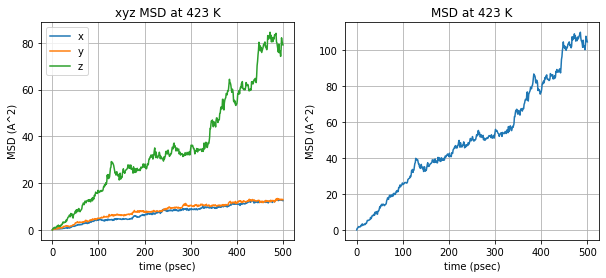

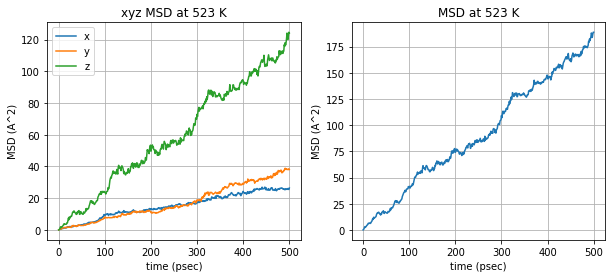

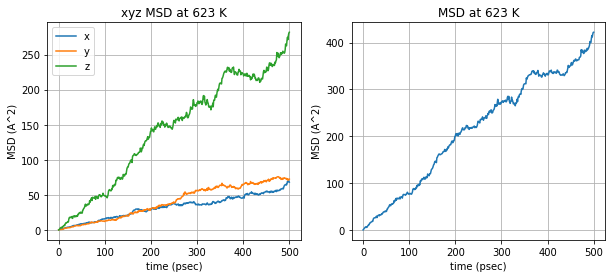

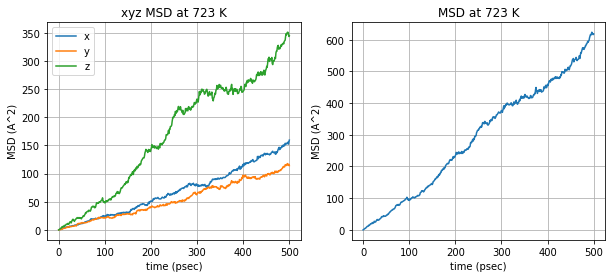

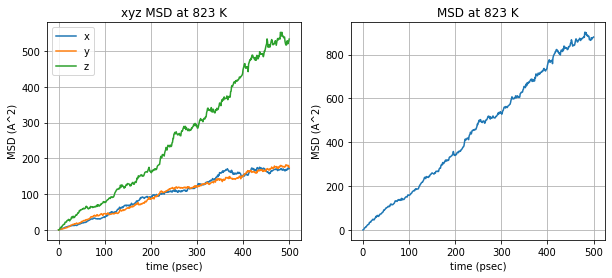

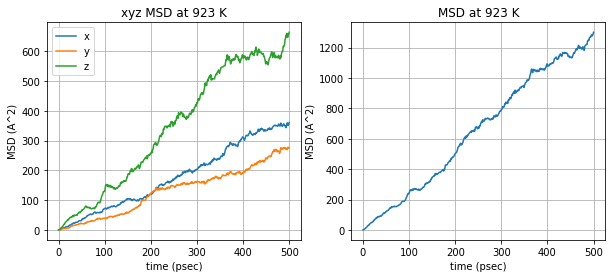

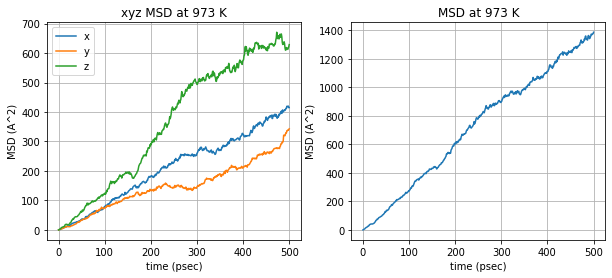

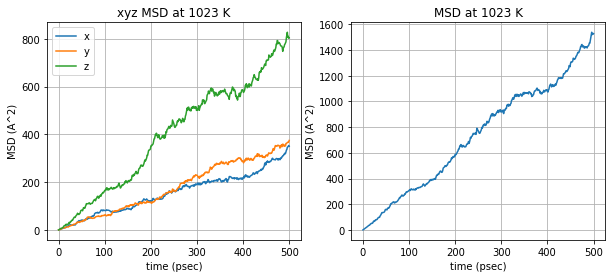

In [14]:
os.makedirs(OUTPUT_DIR / "msd/", exist_ok=True)
D_list = []
for path in trj_list:
    trj = read(path, index="::10")
    Li_index = [Li_i for Li_i, x in enumerate(trj[0].get_chemical_symbols()) if x == 'Li']

    # x,y,z軸ごとにmsd取得
    positions_x = []
    positions_y = []
    positions_z = []
    for i in range(len(trj)):
                   positions_x.append(trj[i].get_positions()[Li_index,0])
                   positions_y.append(trj[i].get_positions()[Li_index,1])
                   positions_z.append(trj[i].get_positions()[Li_index,2])
    msd_x = np.mean((positions_x-positions_x[0])**2, axis = 1)
    msd_y = np.mean((positions_y-positions_y[0])**2, axis = 1)
    msd_z = np.mean((positions_z-positions_z[0])**2, axis = 1)
    
    # msd
    msd = []
    for j in range(len(trj)):
        msd0 = np.mean(np.sum((trj[j].get_positions()[Li_index]-trj[0].get_positions()[Li_index])**2, axis=1))
        msd.append(msd0)
    slope, intercept, r_value, _, _ = stats.linregress(range(len(msd)), msd)
    logD = np.log10(slope*1e-16*1e12/6)
    T = int(os.path.basename(path.split(".")[0].replace("MD_","").replace("traj_and_log/","")))
    D_list.append([T, 1000/T, logD])
    
    fig = plt.figure(figsize=(10,4), facecolor='w')
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(range(len(msd_x)), msd_x, label="x")
    ax1.plot(range(len(msd_y)), msd_y, label="y")
    ax1.plot(range(len(msd_z)), msd_z, label="z")
    ax1.set_xlabel("time (psec)")
    ax1.set_ylabel("MSD (A^2)")
    ax1.legend()
    ax1.set_title("xyz MSD at "+str(T)+" K")
    ax1.grid(True)
    
    #fig = plt.figure()
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(range(len(msd)), msd)
    ax2.set_xlabel("time (psec)")
    ax2.set_ylabel("MSD (A^2)")
    ax2.set_title("MSD at "+str(T)+" K")
    ax2.grid(True)
    
    fig.savefig(path.replace("traj_and_log/", "msd/").replace("traj", "png"))

In [15]:
DF = pd.DataFrame(D_list)

In [16]:
sl, ic, rv, _, _ = stats.linregress(DF[1], DF[2])
print(sl, ic, rv)

-0.8966596411520203 -3.423378101116098 -0.9943500818353143


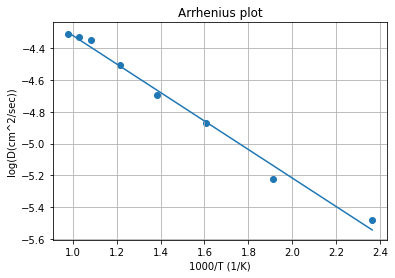

In [17]:
fig = plt.figure()
plt.scatter(DF[1], DF[2])
plt.plot(DF[1], DF[1]*sl+ic)

plt.grid(True)
plt.xlabel("1000/T (1/K)")
plt.ylabel("log(D(cm^2/sec))")
plt.title("Arrhenius plot")
fig.savefig(OUTPUT_DIR / "arrhenius_plot.png")